In [1]:
class Config:
    database_path = './hmscs.db'
    table_field_widths = [13, 10, 10, 10]


import sqlite3

conn = sqlite3.connect(Config.database_path)

cq = conn.cursor()
cq.execute('''
    select HistoryWaveId, DataLength, SampleFreq, SampleTime
    from T_HistoryWave 
    where HistoryWaveId >= 309
    order by SampleTime desc
    limit 50
    '''
)

result = list(cq.fetchall())
print(len(result))

cols =  'HistoryWaveId DataLength SampleFreq SampleTime'.split()
print('%{}s %{}s %{}s %{}s'.format(*Config.table_field_widths) % tuple(cols))

for row in result:
    # print([type(i) for i in row])
    print('%{}d %{}d %{}.0f %{}s'.format(*Config.table_field_widths) % tuple(row))

32
HistoryWaveId DataLength SampleFreq SampleTime
          351       8192      12800 2020-06-19 17:47:11
          350       8192      12800 2020-06-19 17:46:50
          349       8192      12800 2020-06-19 17:46:31
          348       8192      12800 2020-06-19 17:45:37
          347       8192      12800 2020-06-19 17:44:04
          346       8192      12800 2020-06-19 17:43:42
          345       8192      12800 2020-06-19 17:43:24
          344       8192      12800 2020-06-19 17:43:05
          343       8192      12800 2020-06-19 17:41:13
          342       8192      12800 2020-06-19 17:40:54
          341       8192      12800 2020-06-19 17:40:34
          340       8192      12800 2020-06-19 17:40:15
          339       8192      12800 2020-06-19 17:39:14
          338       8192      12800 2020-06-19 17:38:54
          337       8192      12800 2020-06-19 17:38:37
          336       8192      12800 2020-06-19 17:38:14
          335       8192      12800 2020-06-19 17:32:4

In [2]:


class Sample:
    def __init__(self, gear_id, direction, forced, wave):
        self.gear_id = gear_id
        self.direction = direction
        self.forced = forced
        self.wave = wave
        
    def __repr__(self):
        return f'S({self.gear_id} {self.direction:5s} {"f" if self.forced else " "} len={len(self.wave)})'
        


In [3]:
import sqlite3

conn = sqlite3.connect(Config.database_path)
cq = conn.cursor()
cq.execute('''
    select HistoryWaveId, DataLength, SampleFreq, SampleTime, WaveData
    from T_HistoryWave
    where HistoryWaveId >= 309
    order by SampleTime
    '''
)

samples = []

import bz2 as z
import array
for i, (historywaveid, datalength, samplefreq, sampletime, bdata) in enumerate(cq.fetchall()):
    bdata = z.decompress(bdata)
    farr = array.array('f')
    farr.frombytes(bdata)
    
    init = dict(
        gear_id=i//4 + 1,
        direction=['left', 'right'][i%4//2],
        forced=[False, True][i%2],
        wave=farr
    )
    
#     print(f'{historywaveid:3d} {sampletime} {init}')
    s = Sample(**init)
    samples.append(s)
    
    print(s)

S(1 left    len=8192)
S(1 left  f len=8192)
S(1 right   len=8192)
S(1 right f len=8192)
S(2 left    len=8192)
S(2 left  f len=8192)
S(2 right   len=8192)
S(2 right f len=8192)
S(3 left    len=8192)
S(3 left  f len=8192)
S(3 right   len=8192)
S(3 right f len=8192)
S(4 left    len=8192)
S(4 left  f len=8192)
S(4 right   len=8192)
S(4 right f len=8192)
S(5 left    len=8192)
S(5 left  f len=8192)
S(5 right   len=8192)
S(5 right f len=8192)
S(6 left    len=8192)
S(6 left  f len=8192)
S(6 right   len=8192)
S(6 right f len=8192)
S(7 left    len=8192)
S(7 left  f len=8192)
S(7 right   len=8192)
S(7 right f len=8192)
S(8 left    len=8192)
S(8 left  f len=8192)
S(8 right   len=8192)
S(8 right f len=8192)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import contextlib

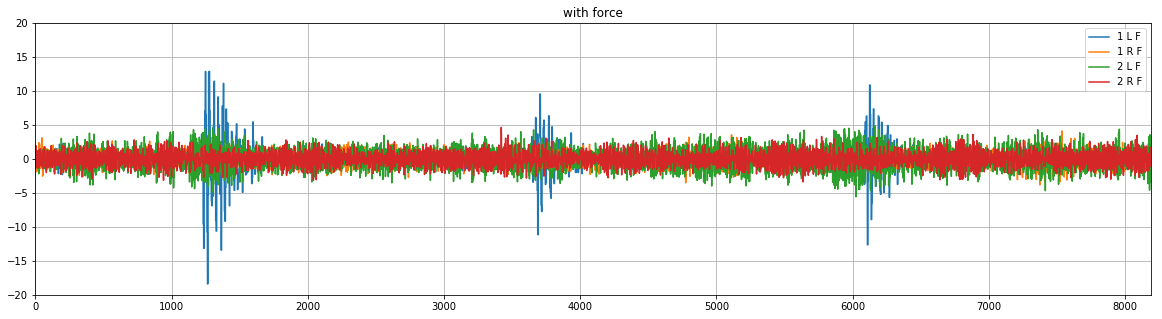

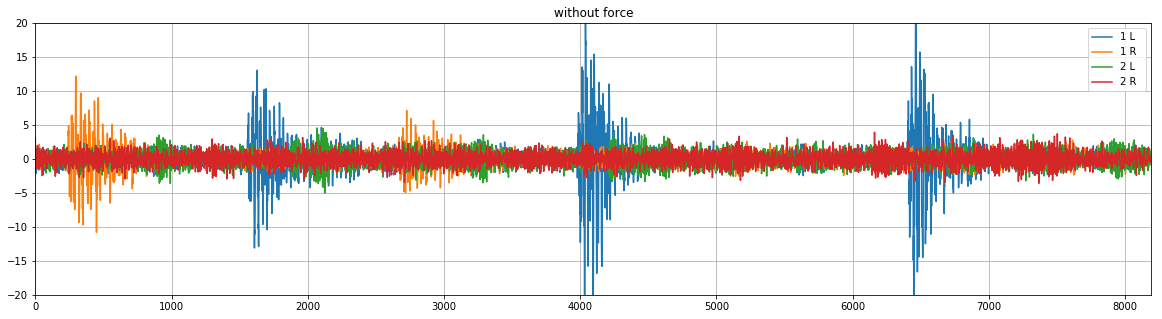

In [6]:

@contextlib.contextmanager
def plot():
    plt.figure(figsize=(20,5))
    yield
    plt.xlim(0, 8192)
    plt.ylim(-20,20)
    plt.grid(True)
    plt.show()
    
def r(s):
    return f'{s.gear_id} {dict(right="R",left="L")[s.direction]} {"F" if s.forced else " "}'

some_samples = samples[:8]

with plot():
    for s in some_samples:
        if s.forced:
            plt.plot(s.wave, label=r(s))
    plt.legend()
    plt.title("with force")
            
with plot():
    for s in some_samples:
        if not s.forced:
            plt.plot(s.wave, label=r(s))
    plt.legend()
    plt.title("without force")



In [7]:
def info_to_index(gear_id, direction, forced):
    return (gear_id-1) * 4 \
        + dict(L=0, R=2)[direction] \
        + {True:1, False:0}[forced]

## Hilbert Enveloping

Tried to use Hilbert transform directly. The result is terrible.

So I tried to apply a low pass filter before enveloping.
The result is better, but the peaks of the waveform are attenuated, which could affect the peak finding step.

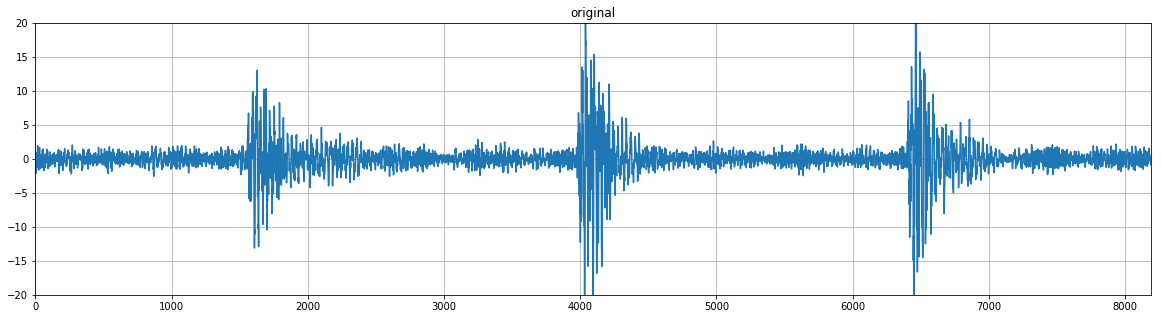

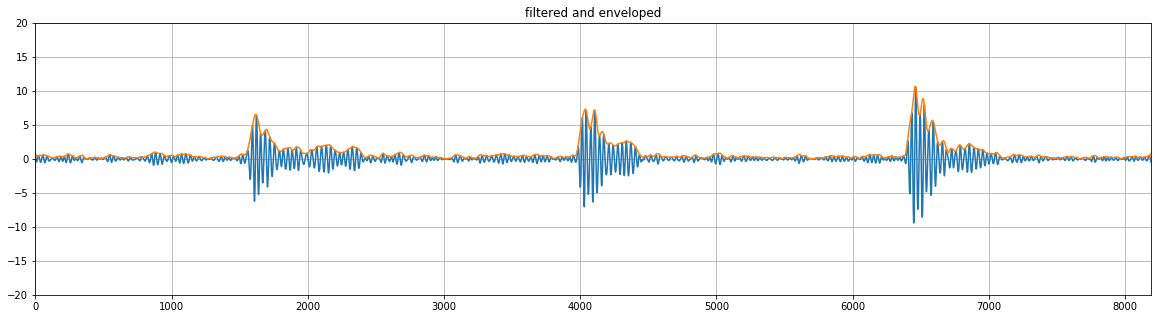

In [8]:
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
    plt.xlim(0, 8192)
    plt.ylim(-20,20)
    plt.grid(True)
    plt.show()
    
from scipy.signal import hilbert, butter, filtfilt


w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='original'):
    plt.plot(signal)

cut_off_freq = 1000/12.8e3
b, a1 = butter(4, cut_off_freq, btype='lowpass')
signal = filtfilt(b, a1, signal)

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

with plot(title='filtered and enveloped'):
    plt.plot(signal)
    plt.plot(amplitude_envelope)


## Empirical Envelope Estimation Algorithm (EEEA)

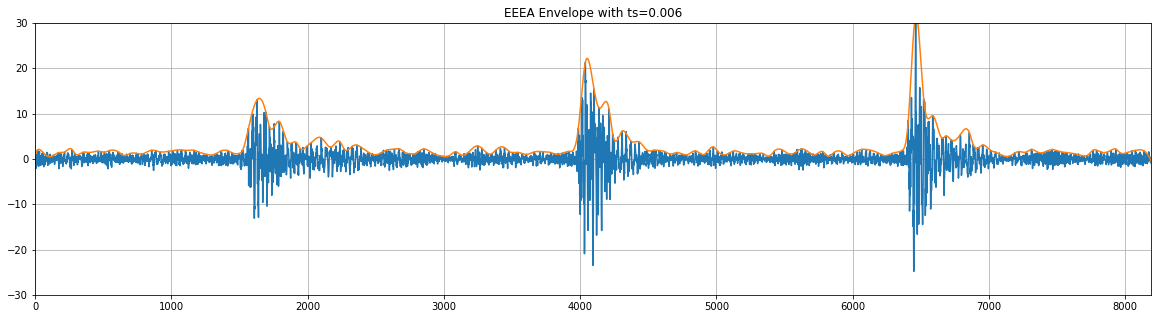

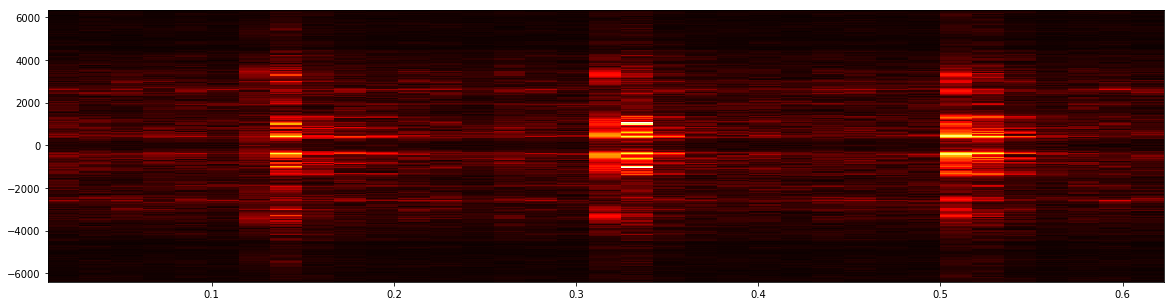

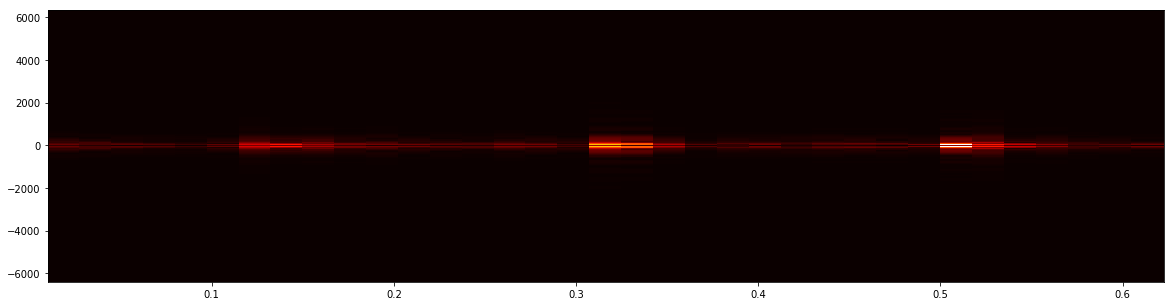

In [9]:
from eeea import eeea


@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
    plt.xlim(0, 8192)
    ylim = 30
    plt.ylim(-ylim,ylim)
    plt.grid(True)
    plt.show()


w = samples[info_to_index(1, 'L', False)]
signal = w.wave
ts = 0.006
envelope = eeea(signal, ts=ts, fs=12800)

with plot(title=f'EEEA Envelope with ts={ts}'):
    plt.plot(signal)
    plt.plot(envelope)
    
from scipy import fftpack
def plot_spectrum(signal, f_s=12800):
#     xlim = 1000
#     plt.xlim(0, xlim)
    plt.xlim(0, f_s/2)
    
    X = fftpack.fft(signal)
    freqs = fftpack.fftfreq(len(signal)) * f_s
    plt.plot(freqs, np.abs(X))
    plt.show()
    
import scipy.signal
import matplotlib.colors as colors
def plot_spectrogram(b, f_s=12800):
    plt.figure(figsize=(20,5))
    b = np.array(b)
    f, t, Sxx = scipy.signal.spectrogram(b, f_s, return_onesided=False)
    plt.pcolormesh(
        t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0), 
        cmap='hot', 
#         norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()),
        norm=colors.PowerNorm(gamma=0.3),
    )
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
    plt.show()
    
# plot_spectrum(signal)
# plot_spectrum(envelope)
plot_spectrogram(signal)
plot_spectrogram(envelope)

In [10]:
w = samples[info_to_index(1, 'L', False)]
signal = w.wave
ts = 0.006
envelope = eeea(signal, ts=ts, fs=12800)

np.save('envelope_1ln', envelope)

In [14]:
npz_dict = {}

for s in samples:
    name = f'{s.gear_id}{dict(right="R",left="L")[s.direction]}{"F" if s.forced else "-"}'
    npz_dict[name] = s.wave
    
np.savez('samples', **npz_dict)